<a href="https://colab.research.google.com/github/Ha-minss/Classes-in-University/blob/main/House_prices_prediction-latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    KFold,
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
    cross_val_predict
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    RobustScaler,
    StandardScaler
)
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (
    RidgeCV,
    LassoCV
)
from sklearn.svm import SVR
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor
)
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
# mlxtend의 StackingCVRegressor를 사용하려면 아래 import 추가
from mlxtend.regressor import StackingCVRegressor

In [2]:
from google.colab import files
files.upload()  # 여기서 kaggle.json 파일 선택

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ehdgk0725","key":"efa68270d8926dcaeb86446184e814ea"}'}

In [3]:
# 1) ~/.kaggle 디렉토리 생성
!mkdir -p ~/.kaggle

# 2) 업로드된 kaggle.json을 이동
!cp kaggle.json ~/.kaggle/

# 3) 권한 설정 (안전하게 읽기 전용)
!chmod 600 ~/.kaggle/kaggle.json

# 4) Kaggle API 클라이언트 설치
!pip install -q kaggle

In [4]:
# Ames Housing 데이터 다운로드
!kaggle competitions download -c house-prices-advanced-regression-techniques

# 압축 해제
!unzip -q house-prices-advanced-regression-techniques.zip -d data

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 632MB/s]


In [5]:
import os
print("data 폴더 내용:", os.listdir("data"))

data 폴더 내용: ['data_description.txt', 'train.csv', 'test.csv', 'sample_submission.csv']


In [6]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv("data/test.csv")

## EDA

In [7]:
display(train_data.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train_data = train_data.drop("Id", axis = 1)
test_data = test_data.drop("Id",axis = 1)
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


<Axes: xlabel='SalePrice', ylabel='Count'>

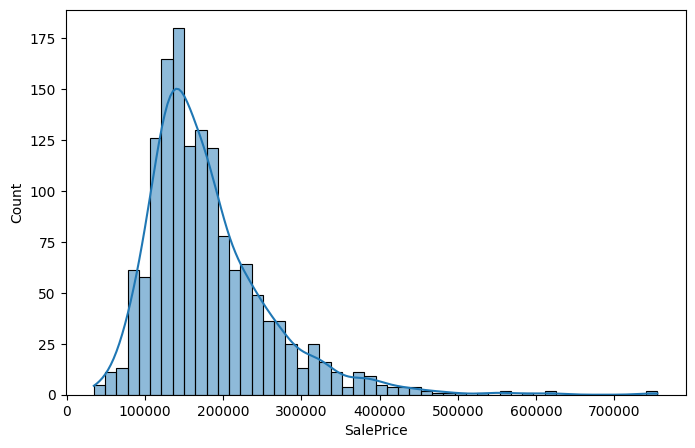

In [11]:
display(train_data["SalePrice"].describe())
plt.figure(figsize=(8, 5))
sns.histplot(train_data['SalePrice'], bins=50, kde=True)

In [12]:
print(list(set(train_data.dtypes.tolist())))

[dtype('float64'), dtype('int64'), dtype('O')]


In [13]:
train_data_num = train_data.select_dtypes(include = ["int64", "float64"])
train_data_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


<Figure size 2000x2000 with 0 Axes>

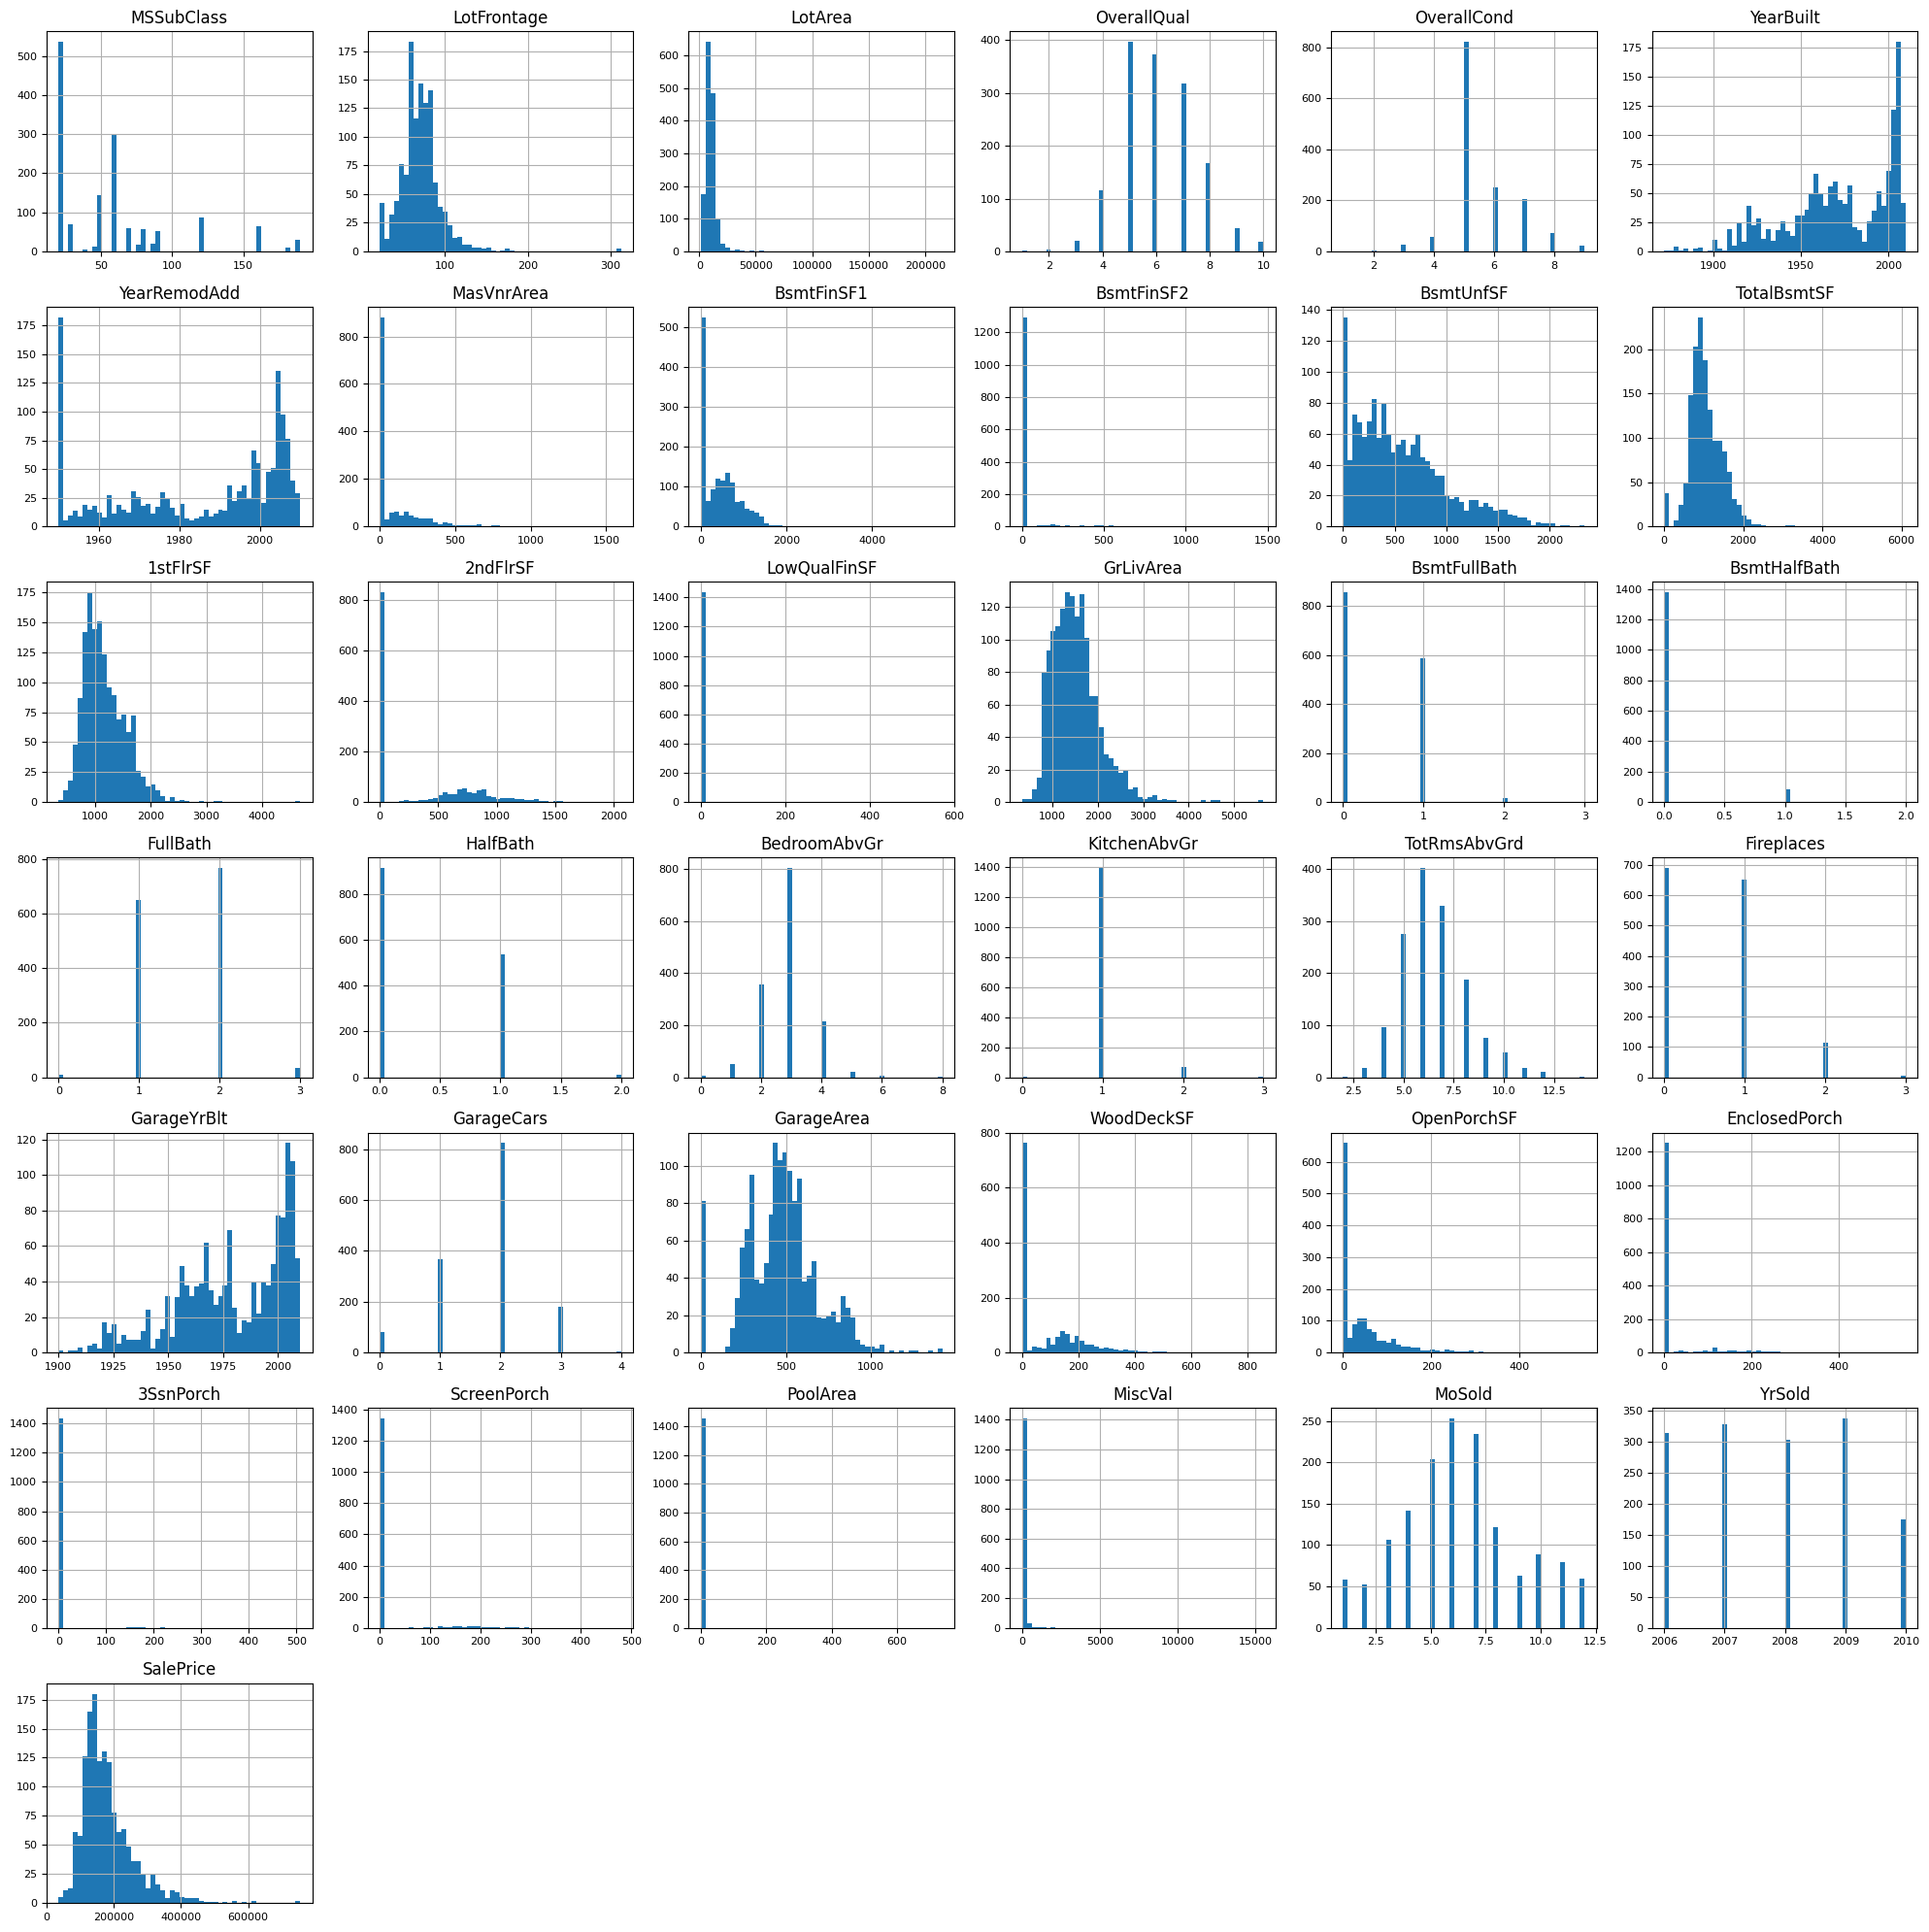

In [14]:
plt.figure(figsize =(20,20))
train_data_num.hist(bins = 50, figsize =(20,20), xlabelsize= 8, ylabelsize= 8)
plt.tight_layout()
plt.show()

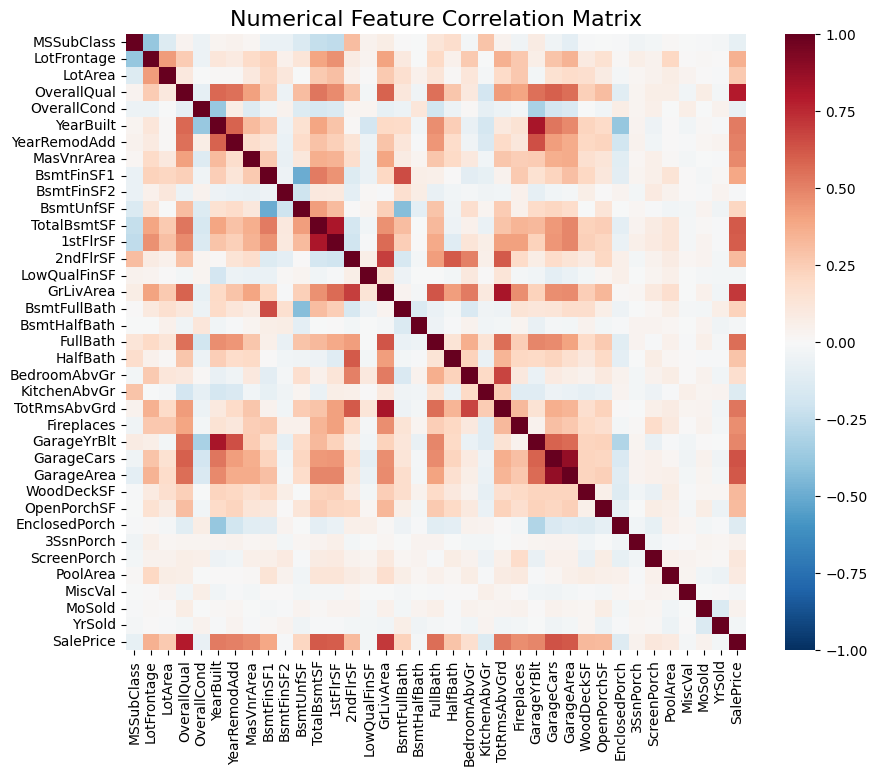

In [15]:
# 1) 숫자형 컬럼만 골라서 상관행렬 계산
#    SalePrice도 포함해서 타깃과의 관계도 함께 살펴보겠습니다.
num_feats = train_data.select_dtypes(include=['int64','float64'])

# 2) 상관행렬
corr_matrix = num_feats.corr()

# 3) 히트맵으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title("Numerical Feature Correlation Matrix", fontsize=16)
plt.show()

In [16]:
# ② SalePrice와의 상관계수만 절댓값 기준으로 정렬
corr_with_target = num_feats.corr()['SalePrice'].abs().sort_values(ascending=False)

# ③ 상위 30개 상관변수 출력 (SalePrice 제외하고)
print("SalePrice와 절댓값 상관계수 상위 30개 변수:")
print(corr_with_target.iloc[1:30])  # 0번째가 항상 SalePrice 본인이기 때문에 1:11로 자름

SalePrice와 절댓값 상관계수 상위 30개 변수:
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
Name: SalePrice, dtype: float64




## 결측치 처리

In [17]:
missing = train_data.isna().sum()
missing_percent = (missing/len(train_data)) * 100
missing_df = pd.DataFrame({
    "column": missing.index,
    "missing count": missing.values,
    "missing percent": missing_percent.values
}).sort_values(by = "missing percent", ascending= False)

display(missing_df.head(20))

,column,missing count,missing percent
71,PoolQC,1453,99.520548
73,MiscFeature,1406,96.301370
5,Alley,1369,93.767123
72,Fence,1179,80.753425
24,MasVnrType,872,59.726027
56,FireplaceQu,690,47.260274
2,LotFrontage,259,17.739726
62,GarageQual,81,5.547945
57,GarageType,81,5.547945
59,GarageFinish,81,5.547945


In [18]:
# 숫자형 컬럼 중 결측이 있는 것만 따로 추출
num_cols_with_na = [col for col in train_data.select_dtypes(include=['int64','float64']).columns
                    if train_data[col].isna().sum() > 0]
num_cols_with_na, len(num_cols_with_na)

(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], 3)

In [19]:
# ① train_data에서 숫자형 결측을 각각 평균으로 채우기
for col in num_cols_with_na:
    mean_val = train_data[col].mean()
    train_data[col].fillna(mean_val, inplace=True)

# ② test_data에도 동일하게 동일한 평균값으로 채우기 (train 평균 사용)
for col in num_cols_with_na:
    mean_val = train_data[col].mean()
    test_data[col].fillna(mean_val, inplace=True)

# 채워졌는지 확인
train_data[num_cols_with_na].isna().sum()

/tmp/ipython-input-19-113597393.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(mean_val, inplace=True)
/tmp/ipython-input-19-113597393.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,0
LotFrontage,0
MasVnrArea,0
GarageYrBlt,0


In [20]:
# 1) object 타입(범주형) 컬럼 중 결측치가 있는 컬럼만 뽑기
cat_cols_with_na = [
    col for col in train_data.select_dtypes(include='object').columns
    if train_data[col].isna().sum() > 0
]
cat_cols_with_na

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [21]:
# 1. 숫자 코드형 컬럼을 문자열로 변환
def convert_numeric_codes(df):
    """MSSubClass, YrSold, MoSold 컬럼을 문자열 타입으로 변환"""
    for col in ['MSSubClass', 'YrSold', 'MoSold']:
        if col in df.columns:
            df[col] = df[col].astype(str)

# 2. 결측치 처리
def handle_missing(df):
    """데이터 설명서와 도메인 지식을 기반으로 결측값을 채웁니다."""
    # Functional: NA는 Typ(일반값)으로
    df['Functional'] = df['Functional'].fillna('Typ')
    # Electrical: NA는 SBrkr(표준 차단기)로
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    # KitchenQual: NA는 TA(보통)로
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    # Exterior1st/Exterior2nd: 최빈값(mode)으로
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    # SaleType: 최빈값으로
    df['SaleType']    = df['SaleType'].fillna(df['SaleType'].mode()[0])
    # MSZoning: MSSubClass별 최빈값으로
    if 'MSZoning' in df.columns:
        df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'] \
                           .transform(lambda x: x.fillna(x.mode()[0]))

    # PoolQC: NA는 'None'(풀 없음)
    df['PoolQC'] = df['PoolQC'].fillna('None')
    # 차고 관련 수치형: NA를 0으로 채움(차고 없음을 의미)
    for col in ['GarageYrBlt','GarageArea','GarageCars']:
        df[col] = df[col].fillna(0)
    # 차고 관련 범주형: NA를 'None'으로
    for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
        df[col] = df[col].fillna('None')
    # 지하실 관련 범주형: NA를 'None'으로
    for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
        df[col] = df[col].fillna('None')

    # LotFrontage: Neighborhood별 중앙값으로 채움
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'] \
                           .transform(lambda x: x.fillna(x.median()))

    # 기타 범주형 컬럼: NA를 'None'으로
    objs = [c for c in df.columns if df[c].dtype == object]
    df[objs] = df[objs].fillna('None')

    # 나머지 수치형 컬럼: NA를 0으로
    dtypes = ['int16','int32','int64','float16','float32','float64']
    nums = [c for c in df.columns if df[c].dtype in dtypes]
    df[nums] = df[nums].fillna(0)

    return df

# 3. 파생 변수 생성
def add_features(df):
    """TotalBaths와 TotalPorchSF 파생 변수를 추가합니다."""
    # 전체 욕실 수 계산: 전층 욕실 + 반욕실(0.5배) + 지하실 욕실
    df['TotalBaths'] = (
        df.get('FullBath', 0)     + 0.5 * df.get('HalfBath', 0) +
        df.get('BsmtFullBath', 0) + 0.5 * df.get('BsmtHalfBath', 0)
    )
    # 전체 현관/데크 면적 합계
    df['TotalPorchSF'] = (
        df.get('WoodDeckSF', 0)   +
        df.get('OpenPorchSF', 0)  +
        df.get('EnclosedPorch', 0)+
        df.get('ScreenPorch', 0)
    )
    return df

# 4. 불필요 또는 중복 컬럼 제거
def drop_redundant(df):
    """파생 변수로 대체되거나 중요도가 낮은 컬럼을 삭제합니다."""
    drop_list = [
        '1stFlrSF','2ndFlrSF',        # 첫/두 번째 층 면적 (GrLivArea만 사용)
        'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','LowQualFinSF',  # 지하실 세부 면적
        'GarageCars',                 # 차고 차량 수 (GarageArea만 사용)
        'FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',  # 개별 욕실 컬럼
        'ExterQual','ExterCond','KitchenQual','BsmtQual','BsmtCond',
        'FireplaceQu','GarageQual','GarageCond',               # 품질 등급 컬럼
        'WoodDeckSF','OpenPorchSF','EnclosedPorch','ScreenPorch', # 현관/포치 구성요소
        'MasVnrType',                  # 석재 마감 유형 (MasVnrArea만 사용)
        'MoSold',                      # 판매 월 (YrSold만 사용)
        'BldgType'                     # 건물 유형 중복 정보
    ]
    existing = [c for c in drop_list if c in df.columns]
    df.drop(columns=existing, inplace=True)

# 5. 전체 전처리 파이프라인 정의
def preprocess(df):
    """전처리 함수를 순차 실행하여 데이터프레임을 정리합니다."""
    convert_numeric_codes(df)
    df = handle_missing(df)
    df = add_features(df)
    drop_redundant(df)
    return df

# 실제 train/test 데이터에 전처리 적용
train_data = preprocess(train_data)
test_data  = preprocess(test_data)

# 결측치 없는지 확인 출력
print("=== train_data 결측치 현황 ===")
print(train_data.isnull().sum())
print("\n=== test_data 결측치 현황 ===")
print(test_data.isnull().sum())

=== train_data 결측치 현황 ===
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrArea       0
Foundation       0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
GrLivArea        0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageArea       0
PavedDrive       0
3SsnPorch        0
PoolArea         0
PoolQC           0
Fence            0
MiscFeature      0
MiscVal          0
YrSold           0
SaleT

## 로그변환 + 원핫인코딩

In [22]:
# 1) train_data에서 수치형 변수들만 골라놓습니다.
num_feats = train_data.select_dtypes(include=['int64','float64']).copy()

# 2) 카테고리처럼 다뤄야 하는 정수형 변수 제외
exclude_list = [
    'MSSubClass', 'KitchenAbvGr', 'BedroomAbvGr', 'TotRmsAbvGrd',
    'HalfBath', 'FullBath', 'BsmtHalfBath', 'BsmtFullBath',
    'GarageCars', 'Fireplaces', 'MiscVal'
]
for col in exclude_list:
    if col in num_feats.columns:
        num_feats.drop(columns=[col], inplace=True)

# 3) 값이 0 이상인 연속형 변수만 남겼는지 확인
cont_feats = [col for col in num_feats.columns if train_data[col].min() >= 0]
print("연속형 + 0 이상 변수들:", cont_feats)

# 4) 왜도 계산
skew_vals = {col: train_data[col].skew() for col in cont_feats}

# 5) 절댓값 왜도 > 0.8인 변수만 필터링 (SalePrice는 제외)
skewed_feats = [col for col, sk in skew_vals.items() if abs(sk) > 0.8 and col != 'SalePrice']
print("절댓값 왜도 > 0.8인 변수들:", skewed_feats)

# 6) 실제 로그 변환 적용
for col in skewed_feats:
    train_data[col] = np.log1p(train_data[col])
    test_data[col]  = np.log1p(test_data[col])

# 7) 변환 후 다시 왜도 확인
for col in skewed_feats:
    print(col, "→ skew(after log):", train_data[col].skew())


연속형 + 0 이상 변수들: ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', '3SsnPorch', 'PoolArea', 'SalePrice', 'TotalBaths', 'TotalPorchSF']
절댓값 왜도 > 0.8인 변수들: ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', '3SsnPorch', 'PoolArea', 'TotalPorchSF']
LotFrontage → skew(after log): -0.8919767349062553
LotArea → skew(after log): -0.13740448122837784
MasVnrArea → skew(after log): 0.48112012705551577
TotalBsmtSF → skew(after log): -5.1546699835179135
GrLivArea → skew(after log): -0.006140253486287248
3SsnPorch → skew(after log): 7.734974870241933
PoolArea → skew(after log): 14.363102459725052
TotalPorchSF → skew(after log): -1.2890089801585893


In [23]:
# 1) SalePrice를 로그 변환해 새 칼럼 생성
train_data['SalePrice_log'] = np.log1p(train_data['SalePrice'])

# 2) 범주형(col type 'object') 칼럼 목록
cat_cols = train_data.select_dtypes(include='object').columns.tolist()

# 3) train/test 합치기 (이때 'SalePrice'와 'SalePrice_log'만 drop)
df_all = pd.concat(
    [
        train_data.drop(columns=['SalePrice', 'SalePrice_log']),
        test_data.copy()
    ],
    axis=0,
    ignore_index=True
)

# 4) 범주형 → 원-핫 인코딩 (drop_first=True)
df_all = pd.get_dummies(df_all, columns=cat_cols, drop_first=True)

# 5) 다시 train/test로 분리
n_train = train_data.shape[0]

X      = df_all.iloc[:n_train,  :].copy().reset_index(drop=True)
X_test = df_all.iloc[n_train:, :].copy().reset_index(drop=True)
y      = train_data['SalePrice_log'].copy().reset_index(drop=True)

print("X shape:", X.shape)
print("X_test shape:", X_test.shape)
print("y shape:", y.shape)

X shape: (1460, 223)
X_test shape: (1459, 223)
y shape: (1460,)


In [24]:
# 교차검증 설정 (12-fold)
kf = KFold(n_splits=12, shuffle=True, random_state=42)

def cv_rmse(model, X, y):
    scores = cross_val_score(model, X, y,
                             scoring='neg_mean_squared_error',
                             cv=kf, n_jobs=-1)
    return np.sqrt(-scores)

# 개별 모델 딕셔너리
models = {
    'ridge': make_pipeline(RobustScaler(), RidgeCV(alphas=[1e-15,1e-10,1e-8,9e-4,7e-4,5e-4,3e-4,1e-4,1e-3,5e-2,1e-2,0.1,0.3,1,3,5,10,15,18,20,30,50,75,100], cv=kf)),
    'svr': make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003)),
    'gbr': GradientBoostingRegressor(n_estimators=6000, learning_rate=0.01, max_depth=4,
                                     max_features='sqrt', min_samples_leaf=15,
                                     min_samples_split=10, loss='huber', random_state=42),
    'rf': RandomForestRegressor(n_estimators=1200, max_depth=15, min_samples_split=5,
                                min_samples_leaf=5, oob_score=True, random_state=42),
    'xgboost': XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0,
                            learning_rate=0.01, n_estimators=6000, max_depth=4,
                            objective='reg:squarederror', random_state=42),
}


# 빈 딕셔너리 준비 (모델 학습 결과 보관)
trained_models = {}

In [25]:
trained_models = {}
for name, model in models.items():
    # LightGBM 은 내부 CV 를 쓰므로 여기서 스킵
    if name == 'lightgbm':
        continue

    scores = cv_rmse(model, X, y)
    print(f"{name:10s} CV RMSE: {scores.mean():.5f} ± {scores.std():.5f}")
    model.fit(X, y)
    trained_models[name] = model

ridge      CV RMSE: 0.12831 ± 0.02766


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.43446e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.79352e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.78345e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.78477e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarnin

svr        CV RMSE: 0.13998 ± 0.03169
gbr        CV RMSE: 0.12116 ± 0.02525
rf         CV RMSE: 0.14452 ± 0.02468


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


xgboost    CV RMSE: 0.13005 ± 0.02046


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:38:21] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:38:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:38:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
import lightgbm as lgb

# 1) Dataset 준비
lgb_train = lgb.Dataset(X, label=y)

# 2) 파라미터 정의
params = {
    'objective': 'regression',
    'device': 'gpu',
    'learning_rate': 0.01,
    'num_leaves': 6,
    'max_bin': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 4,
    'feature_fraction': 0.2,
    'min_sum_hessian_in_leaf': 11,
    'verbose': -1,
    'seed': 42
}

# 3) 내부 CV 실행 (folds=kf, callbacks 사용)
cv_results = lgb.cv(
    params,
    lgb_train,
    num_boost_round=3500,
    folds=kf,                             # <-- 여기서 kf (KFold 객체) 전달
    metrics='rmse',
    seed=42,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

# 4) 최적 boosting round 확인
first_key  = list(cv_results.keys())[0]           # 'valid rmse-mean'
best_rounds = len(cv_results[first_key])          # 반복 횟수
best_rmse   = min(cv_results[first_key])          # 최소 RMSE
print(f"Best rounds: {best_rounds}, Best CV RMSE: {best_rmse:.5f}")

# 5) 최종 모델 학습
final_lgb = lgb.train(params, lgb_train, num_boost_round=best_rounds)

# 6) 예측
pred_log_lgb = final_lgb.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 50 rounds
[100]	cv_agg's valid rmse: 0.252221 + 0.0316231
[200]	cv_agg's valid rmse: 0.188786 + 0.0286306
[300]	cv_agg's valid rmse: 0.160017 + 0.0258042
[400]	cv_agg's valid rmse: 0.1463 + 0.0242675
[500]	cv_agg's valid rmse: 0.139434 + 0.0231423
[600]	cv_agg's valid rmse: 0.135265 + 0.0225153
[700]	cv_agg's valid rmse: 0.132688 + 0.0219258
[800]	cv_agg's valid rmse: 0.130715 + 0.0213779
[900]	cv_agg's valid rmse: 0.129311 + 0.0208948
[1000]	cv_agg's valid rmse: 0.128292 + 0.0206401
[1100]	cv_agg's valid rmse: 0.127575 + 0.0204114
[1200]	cv_agg's valid rmse: 0.127027 + 0.020166
[1300]	cv_agg's valid rmse: 0.126576 + 0.0199343
[1400]	cv_agg's valid rmse: 0.126183 + 0.0196493
[1500]	cv_agg's valid rmse: 0.125979 + 0.0194438
[1600]	cv_agg's valid rmse: 0.125759 + 0.0193025
[1700]	cv_agg's valid rmse: 0.125432 + 0.0190155
[1800]	cv_agg's valid rmse: 0.125291 + 0.018813
[1900]	cv_agg's valid rmse: 0.12519 + 0.0186963
[2000]	cv_agg's valid 

In [27]:
# 2) scikit-learn 래퍼 모델 정의
lgb_sklearn = LGBMRegressor(
    device='gpu',
    objective='regression',
    learning_rate=0.01,
    num_leaves=6,
    n_estimators=best_rounds,      # 내부 CV에서 찾은 최적 라운드
    max_bin=200,
    bagging_fraction=0.8,
    bagging_freq=4,
    feature_fraction=0.2,
    min_sum_hessian_in_leaf=11,
    verbose=-1,
    random_state=42
)

# 3) 전체 데이터로 학습
lgb_sklearn.fit(X, y)

# 4) trained_models 에 추가
trained_models['lightgbm'] = lgb_sklearn

print("LightGBM sklearn wrapper 학습 완료 —", best_rounds, "rounds")

LightGBM sklearn wrapper 학습 완료 — 2136 rounds


In [28]:
print("학습된 모델 리스트:", list(trained_models.keys()))

학습된 모델 리스트: ['ridge', 'svr', 'gbr', 'rf', 'xgboost', 'lightgbm']


In [29]:
def train_stacking_only(trained, X, y, meta_params=None):
    """
    trained: 이미 전체 데이터로 학습된 base 모델 딕셔너리
    X, y: 원본 학습 데이터
    meta_params: 메타 모델 파라미터(dict), None이면 기본 XGB
    반환: 학습된 메타 모델
    """
    # 1) Base 모델 OOF 예측 (out-of-fold predictions)
    meta_feats = []
    for name, model in trained.items():
        preds = cross_val_predict(
            model, X, y,
            cv=kf,
            method='predict',
            n_jobs=1      # ← 여기만 변경: 워커 수를 1로 제한
        )
        meta_feats.append(preds.reshape(-1,1))
    meta_X = np.hstack(meta_feats)

    # 2) 메타 모델 정의 및 학습
    from xgboost import XGBRegressor
    if meta_params is None:
        meta_params = {
            'tree_method': 'gpu_hist',
            'device': 'cuda',
            'learning_rate': 0.01,
            'n_estimators': 6000,
            'max_depth': 4,
            'objective': 'reg:squarederror',
            'random_state': 42
        }
    meta_model = XGBRegressor(**meta_params)
    meta_model.fit(meta_X, y)

    return meta_model


# 3) 메타 모델만 빠르게 학습
meta_model = train_stacking_only(trained_models, X, y)
trained_models['stack'] = meta_model
print("메타 모델 학습 완료")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.93067e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.79494e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.47798e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=8.77344e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarnin

메타 모델 학습 완료


In [30]:
def blended_predictions(X):
    """
    X: 원본 피처 행렬 (n_samples, n_features)
    반환: blended 예측 (로그 스케일)
    """
    # 1) Base 모델 예측값 배열 생성
    preds_ridge    = trained_models['ridge'].predict(X)
    preds_svr      = trained_models['svr'].predict(X)
    preds_gbr      = trained_models['gbr'].predict(X)
    preds_rf       = trained_models['rf'].predict(X)
    preds_xgboost  = trained_models['xgboost'].predict(X)
    preds_lgb      = trained_models['lightgbm'].predict(X)

    # 2) 메타 피처 배열 (n_samples x 6)
    meta_test = np.vstack([
        preds_ridge,
        preds_svr,
        preds_gbr,
        preds_rf,
        preds_xgboost,
        preds_lgb
    ]).T

    # 3) 스태킹 예측
    preds_stack = trained_models['stack'].predict(meta_test)

    # 4) 최종 블렌딩
    return (
        0.10 * preds_ridge +
        0.20 * preds_svr +
        0.10 * preds_gbr +
        0.05 * preds_rf +
        0.10 * preds_xgboost +
        0.10 * preds_lgb +
        0.35 * preds_stack
    )


In [32]:
# --- 셀 5: 블렌딩 예측 실행 및 결과 저장 ---
pred_log = blended_predictions(X_test)
pred = np.expm1(pred_log)
print("예측값 샘플:", pred[:10])

예측값 샘플: [123822.88240818 166341.92666806 178903.55606431 197820.68499275
 185732.18199903 176549.35055924 174919.51568998 166695.57004527
 195815.55605133 118522.99762745]


In [36]:
class BlendEstimator(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y):
        # 아무것도 학습할 필요 없습니다.
        return self

    def predict(self, X):
        return blended_predictions(X)

    def get_params(self, deep=True):
        # 파라미터가 없으므로 빈 dict 반환
        return {}

    def set_params(self, **params):
        # 파라미터가 없으므로 그대로 self 반환
        return self

def cv_rmse_blend(X, y, cv):
    """블렌딩 예측에 대한 CV RMSE를 계산"""
    estimator = BlendEstimator()
    scores = cross_val_score(
        estimator,     # 위치 인자 1: 추정기
        X,             # 위치 인자 2: 입력
        y,             # 위치 인자 3: 레이블
        scoring='neg_mean_squared_error',
        cv=cv,
        n_jobs=1
    )
    return np.sqrt(-scores)

# 사용 예
rmse_scores = cv_rmse_blend(X, y, kf)
print(f"Blended CV RMSE: {rmse_scores.mean():.5f} ± {rmse_scores.std():.5f}")

Blended CV RMSE: 0.08278 ± 0.01560
